In [1]:
# Jupyter magic
%matplotlib inline
%load_ext autoreload
%autoreload 2

C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\__init__.py:1405: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


Experiment: 0
True coef:(147: 1.00), (163: 1.00)
Direct coef:(1: 0.05), (2: 0.07), (3: 0.11), (4: 0.06), (5: 0.02), (7: 0.11), (9: 0.17), (11: 0.10), (13: 0.02), (15: 0.08), (16: 0.08), (20: 0.07), (21: 0.00), (23: 0.10), (25: 0.02), (30: 0.05), (37: 0.06), (38: 0.08), (39: 0.19), (40: 0.07), (41: 0.10), (42: 0.06), (43: 0.03), (46: 0.08), (49: 0.08), (52: 0.05), (53: 0.10), (56: 0.05), (58: 0.19), (60: 0.16), (61: 0.05), (62: 0.05), (65: 0.00), (66: 0.01), (68: 0.05), (73: 0.11), (74: 0.01), (75: 0.08), (76: 0.09), (79: 0.03), (80: 0.05), (85: 0.06), (86: 0.03), (90: 0.01), (95: 0.09), (96: 0.10), (97: 0.08), (101: 0.01), (102: 0.00), (103: 0.07), (104: 0.00), (107: 0.02), (109: 0.06), (114: 0.06), (115: 0.07), (116: 0.08), (117: 0.03), (118: 0.07), (120: 0.14), (121: 0.03), (124: 0.04), (128: 0.04), (129: 0.02), (132: 0.06), (135: 0.07), (137: 0.06), (138: 0.11), (139: 0.03), (140: 0.04), (141: 0.02), (143: 0.14), (145: 0.03), (146: 0.04), (147: 1.14), (149: 0.02), (155: 0.09), (160:

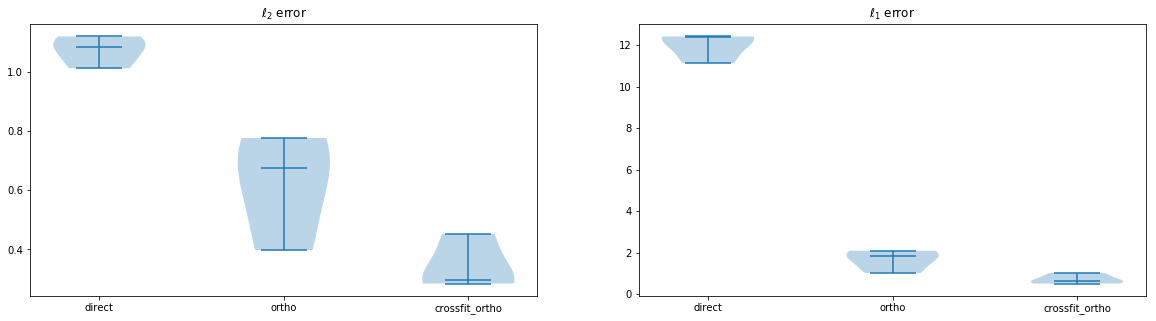

In [24]:
from sklearn.linear_model import Lasso, MultiTaskLasso, MultiTaskLassoCV, LinearRegression
import matplotlib.pyplot as plt
import numpy as np
from logistic_te import gen_data, direct_fit, dml_fit, dml_crossfit


def main():
    n_samples = 5000 # samples used for estimation
    dim_x = 200 # dimension of controls x
    dim_z = 200 # dimension of variables used for heterogeneity (subset of x)
    kappa_x = 38 # support size of control function
    kappa_theta = 2 # support size of target parameter
    sigma_eta = 5 # variance of error in secondary moment equation
    lambda_coef = 1 # coeficient in front of the asymptotic rate for regularization lambda

    l2_direct = []
    l2_ortho = []
    l2_cross_ortho = []
    l1_direct = []
    l1_ortho = []
    l1_cross_ortho = []
    for step in range(3):
        print("Experiment: {}".format(step))
        # Generate data
        x, t, z, y, support_x, support_theta, alpha_x, beta_x, theta =\
                gen_data(n_samples, dim_x, dim_z, kappa_x, kappa_theta, sigma_eta)
        true_coef = np.zeros((dim_z, 1))
        true_coef[support_theta] = theta
        print('True coef:' + ', '.join(["({}: {:.2f})".format(ind, c) for ind, c in enumerate(true_coef.flatten()) if c>0.001]))
        
        # Direct lasso for all coefficients
        model_y, model_t= direct_fit(x, t, z, y)
        print('Direct coef:' + ', '.join(["({}: {:.2f})".format(ind, c) for ind, c in enumerate(model_y.coef_.flatten()[:dim_z]) if c>0.001]))
        l1_direct.append(np.linalg.norm(model_y.coef_.flatten()[:z.shape[1]] - true_coef.flatten(), ord=1))
        l2_direct.append(np.linalg.norm(model_y.coef_.flatten()[:z.shape[1]].flatten() - true_coef.flatten(), ord=2))
        
        # Orthogonal lasso estimation
        ortho_coef = dml_fit(x, t, z, y)
        l1_ortho.append(np.linalg.norm(ortho_coef.flatten() - true_coef.flatten(), ord=1))
        l2_ortho.append(np.linalg.norm(ortho_coef.flatten() - true_coef.flatten(), ord=2))
        print('Ortho coef:' + ', '.join(["({}: {:.2f})".format(ind, c) for ind, c in enumerate(ortho_coef) if c>0.001]))
        
        # Crossfit Orthogonal lasso estimation
        ortho_coef = dml_crossfit(x, t, z, y)
        l1_cross_ortho.append(np.linalg.norm(ortho_coef - true_coef.flatten(), ord=1))
        l2_cross_ortho.append(np.linalg.norm(ortho_coef - true_coef.flatten(), ord=2))
        print('CrossOrtho coef:' + ', '.join(["({}: {:.2f})".format(ind, c) for ind, c in enumerate(ortho_coef) if c>0.001]))


    plt.figure(figsize=(20, 5))
    plt.subplot(1,2,1)
    plt.violinplot([np.array(l2_direct), np.array(l2_ortho), np.array(l2_cross_ortho)], showmedians=True)
    plt.xticks([1,2,3], ['direct', 'ortho', 'crossfit_ortho'])
    plt.title('$\ell_2$ error')
    plt.subplot(1,2,2)
    plt.violinplot([np.array(l1_direct), np.array(l1_ortho), np.array(l1_cross_ortho)], showmedians=True)
    plt.xticks([1,2,3], ['direct', 'ortho', 'crossfit_ortho'])
    plt.title('$\ell_1$ error')
    plt.show()
    
main()